In [1]:
from skfem import *
import numpy as np
from skfem.utils import solver_iter_krylov
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

# exact value of u and du

def exact_u(x, y):
    return sin(pi * x) * sin(pi * y)

def dexact_u(x, y):
    dux = pi * cos(pi * x) * sin(pi * y)
    duy = pi * cos(pi * y) * sin(pi * x)
    return dux, duy

# errors

@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2


def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))

# forms

@LinearForm
def f_load(v, w):
    pix = pi * w.x[0]
    piy = pi * w.x[1]
    return (2 * pi**2 * sin(pix) * sin(piy)) * v


@BilinearForm
def laplace(u, v, w):
    return dot(grad(u), grad(v))

# solving

m = MeshTri()

for i in range(1, 8):
    m.refine()
    element = ElementTriP2()
    basis = InteriorBasis(m, element, intorder=3)

    K1 = asm(laplace, basis)
    f1 = asm(f_load, basis)

    uh = solve(*condense(K1, f1, D=m.boundary_nodes()),
               solver=solver_iter_krylov(tol=1e-8))
    
    U = basis.interpolate(uh).value

    L2u = np.sqrt(L2uError.assemble(basis, w=U))
    Du = get_DuError(basis, uh)
    H1u = Du + L2u
    print('L2: ', L2u)
    print('H1: ', H1u)

L2:  0.3701821308162362
H1:  1.8337156693985683
L2:  0.15740572307705145
H1:  1.2502164229785424
L2:  0.07479121383890937
H1:  0.8525347535661557
L2:  0.03703703290581105
H1:  0.5891783044781566
L2:  0.018522289815901757
H1:  0.40997857616261413
L2:  0.009274842111763961
H1:  0.28649644653428563
L2:  0.004642509304282054
H1:  0.20082649383661721


In [3]:
from skfem import *
import numpy as np
from skfem.visuals.matplotlib import draw, plot
from skfem.utils import solver_iter_krylov
from skfem.helpers import d, dd, ddd, dot, ddot, grad, dddot, prod
from scipy.sparse.linalg import LinearOperator, minres
from skfem import *
from skfem.models.poisson import *
from skfem.assembly import BilinearForm, LinearForm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.dpi'] = 200

pi = np.pi
sin = np.sin
cos = np.cos
exp = np.exp

## Problem1


\begin{aligned}
\left(\nabla w_{h}, \nabla \chi_{h}\right) &=\left(f, \chi_{h}\right) & & \forall \chi_{h} \in W_{h}
\end{aligned}

## Forms and errors

In [100]:
def exact_u(x, y):
    return sin(pi * x) * sin(pi * y)


def dexact_u(x, y):
    dux = pi * cos(pi * x) * sin(pi * y)
    duy = pi * cos(pi * y) * sin(pi * x)
    return dux, duy

In [101]:
@Functional
def L2uError(w):
    x, y = w.x
    return (w.w - exact_u(x, y))**2


def get_DuError(basis, u):
    duh = basis.interpolate(u).grad
    x = basis.global_coordinates().value
    dx = basis.dx  # quadrature weights
    dux, duy = dexact_u(x[0], x[1])
    return np.sqrt(np.sum(((duh[0] - dux)**2 + (duh[1] - duy)**2) * dx))


@LinearForm
def f_load(v, w):
    global ww
    ww = w
    pix = pi * w.x[0]
    piy = pi * w.x[1]
    return (2 * pi**2 * sin(pix) * sin(piy)) * v


@BilinearForm
def laplace(u, v, w):
    return dot(grad(u), grad(v))

In [107]:
m = MeshTri()

for i in range(1, 8):
    m.refine()
    element = ElementTriP2()
    basis = InteriorBasis(m, element, intorder=3)

    K1 = asm(laplace, basis)
    f1 = asm(f_load, basis)

    uh = solve(*condense(K1, f1, D=m.boundary_nodes()),
               solver=solver_iter_krylov(tol=1e-8))
    
    U = basis.interpolate(uh).value

    L2u = np.sqrt(L2uError.assemble(basis, w=U))
    Du = get_DuError(basis, uh)
    H1u = Du + L2u
    print('L2: ', L2u)
    print('H1: ', H1u)
    
whp2 = wh

L2:  0.3701821308162362
H1:  1.8337156693985683
L2:  0.15740572307705145
H1:  1.2502164229785424
L2:  0.07479121383890937
H1:  0.8525347535661557
L2:  0.03703703290581105
H1:  0.5891783044781566
L2:  0.018522289815901757
H1:  0.40997857616261413
L2:  0.009274842111763961
H1:  0.28649644653428563
L2:  0.004642509304282054
H1:  0.20082649383661721


In [98]:
# W.shape # basis.interpolate(wh).value.shape

# ww.x.shape

# whp1.shape

# basis.doflocs.shape

u = exact_u(basis.doflocs[0], basis.doflocs[1])

u.shape

basis.global_coordinates().value.shape

whp2.shape

x = basis.doflocs[0]
y = basis.doflocs[1]
u = exact_u(x, y)

u.shape

basis.doflocs.shape

sum(u-whp2)/u.shape[0]

-0.004528293030090268

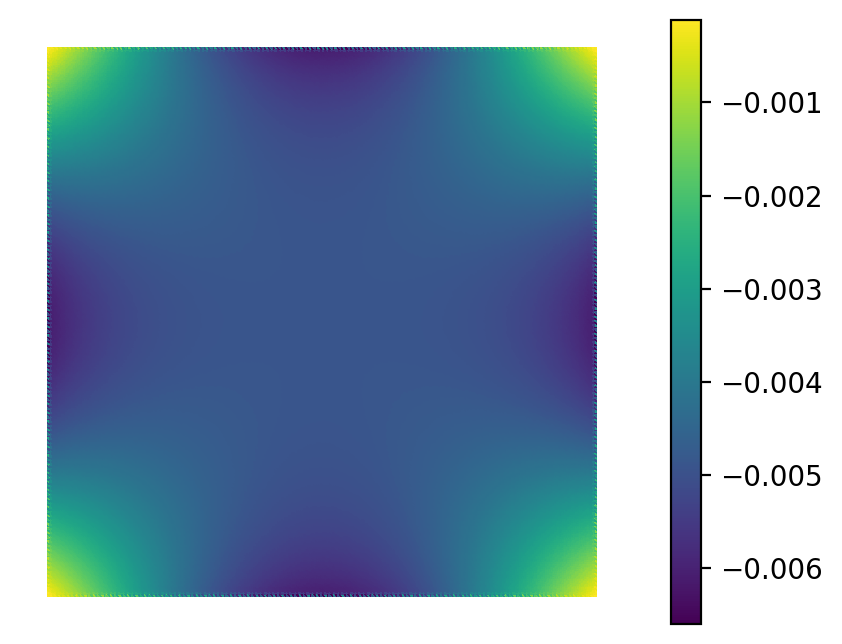

In [99]:
plot(basis, u-whp2, colorbar=True)

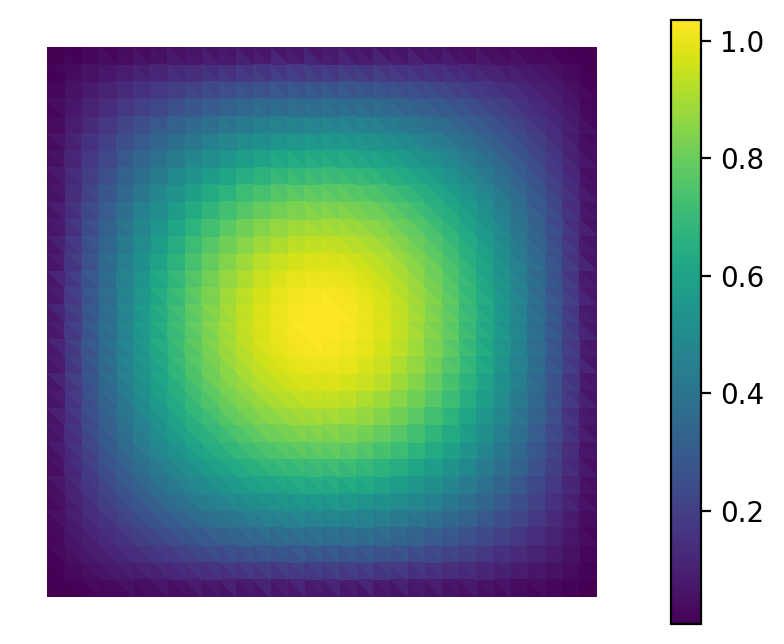

In [51]:
plot(basis, whp2, colorbar=True)

In [32]:
m = MeshTri()

for i in range(1, 5):
    m.refine()
    element = ElementTriP1()
    basis = InteriorBasis(m, element, intorder=3)

    K1 = asm(laplace, basis)
    f1 = asm(f_load, basis)

    wh = solve(*condense(K1, f1, D=m.boundary_nodes()),
               solver=solver_iter_krylov())
    
    W = basis.interpolate(wh).value

    L2u = np.sqrt(L2uError.assemble(basis, w=W))
    Du = get_DuError(basis, wh)
    H1u = Du + L2u
    print('L2: ', L2u)
    print('H1: ', H1u)
    
whp1 = wh

L2:  0.23454870409554232
H1:  1.7465855187185302
L2:  0.07562498200737637
H1:  0.9159326980047305
L2:  0.020330282249165717
H1:  0.45236988511472537
L2:  0.00518149362351155
H1:  0.22274872239638108
